# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# # Intstall PyTorch and download data
# !pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2020-03-27 19:01:33--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-03-27 19:01:33--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [2]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

import itertools

In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [4]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [6]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [7]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [8]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct_samples = 0
    total_samples = 0
    for x, y in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]
    accuracy = float(correct_samples) / total_samples
    return accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.416580, Train accuracy: 0.525424, Val accuracy: 0.734489
Average loss: 0.700145, Train accuracy: 0.786558, Val accuracy: 0.794690
Average loss: 0.602223, Train accuracy: 0.819438, Val accuracy: 0.829500
Average loss: 0.551862, Train accuracy: 0.833515, Val accuracy: 0.842263
Average loss: 0.519409, Train accuracy: 0.845647, Val accuracy: 0.827998


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [9]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

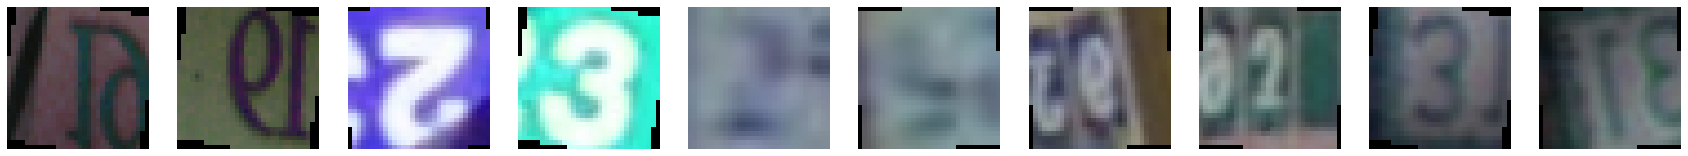

In [10]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

**Ответ**

Не все аугментации оказываются полезными. Например, кажется, что горизонтальные и вертикальные отражения только запутывают нашу сеть. Действительно, вертикальное + горизонтальное отражение цифры `9` может сделать из нее `6`, а горизонтальное отражение цифр создает несуществующие цифры. Если наша цель - не предсказывать цифры в зеркальном отражении, то эти две аугментации стоит убрать, что я делаю ниже.

In [11]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [12]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.612859, Train accuracy: 0.814592, Val accuracy: 0.804450
Average loss: 0.559228, Train accuracy: 0.830137, Val accuracy: 0.832571
Average loss: 0.545853, Train accuracy: 0.834403, Val accuracy: 0.849840
Average loss: 0.528114, Train accuracy: 0.838839, Val accuracy: 0.858098
Average loss: 0.514099, Train accuracy: 0.843992, Val accuracy: 0.857621


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [13]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.Tanh(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(6, 16, 5),
    nn.Tanh(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(16, 120, 5),
    nn.Tanh(),
    Flattener(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10)
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [14]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.263467, Train accuracy: 0.572945, Val accuracy: 0.814620
Average loss: 0.578812, Train accuracy: 0.824779, Val accuracy: 0.862398
Average loss: 0.491696, Train accuracy: 0.849964, Val accuracy: 0.867518
Average loss: 0.445850, Train accuracy: 0.863086, Val accuracy: 0.877688
Average loss: 0.413883, Train accuracy: 0.873170, Val accuracy: 0.876868
Average loss: 0.393378, Train accuracy: 0.878903, Val accuracy: 0.880827
Average loss: 0.378818, Train accuracy: 0.882640, Val accuracy: 0.886970
Average loss: 0.362343, Train accuracy: 0.888390, Val accuracy: 0.886492
Average loss: 0.345136, Train accuracy: 0.894584, Val accuracy: 0.890588
Average loss: 0.335442, Train accuracy: 0.895983, Val accuracy: 0.884240


# Подбор гиперпараметров

In [15]:
def train_model_with_sched(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        current_lr = optimizer.param_groups[0]['lr']
        for i_step, (x, y) in enumerate(train_loader):


            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        if scheduler:
            scheduler.step()
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [24]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_coeff', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-1, 1e-2, 1e-3]
anneal_coeff = [0.2, 0.9]
anneal_epochs = [5]
reg = [1e-4, 1e-5]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

# TODO: Your code here!
for lr, ac, ae, reg in itertools.product(learning_rates, anneal_coeff, anneal_epochs, reg):
    print(f'Current set of parameters is: learning rate = {lr}, anneal_coeff = {ac}, anneal_epoch = {ae}, reg = {reg}')
    lenet_model = nn.Sequential(
        nn.Conv2d(3, 6, 5),
        nn.Tanh(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(6, 16, 5),
        nn.Tanh(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(16, 120, 5),
        nn.Tanh(),
        Flattener(),
        nn.Linear(120, 84),
        nn.Tanh(),
        nn.Linear(84, 10)
    )

    lenet_model.type(torch.cuda.FloatTensor)
    lenet_model.to(device)

#     optimizer = torch.optim.Adam(lenet_model.parameters(), lr=lr, weight_decay=reg)
    optimizer = optim.SGD(lenet_model.parameters(), lr=lr, weight_decay=reg)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=ae, gamma=ac)

    loss_history, train_history, val_history = train_model_with_sched(lenet_model,
                                                           train_aug_loader,
                                                           val_loader,
                                                           loss,
                                                           optimizer,
                                                           epoch_num,
                                                           scheduler)
    running_res = RunResult(lenet_model, train_history, val_history, val_history[-1])
    params = Hyperparams(lr, ac, ae, reg)
    run_record[params] = running_res

Current set of parameters is: learning rate = 0.1, anneal_coeff = 0.2, anneal_epoch = 5, reg = 0.0001
Average loss: 1.259183, Train accuracy: 0.581596, Val accuracy: 0.829909
Average loss: 0.572005, Train accuracy: 0.826178, Val accuracy: 0.861921
Average loss: 0.490214, Train accuracy: 0.849538, Val accuracy: 0.876459
Average loss: 0.443750, Train accuracy: 0.863290, Val accuracy: 0.879121
Average loss: 0.414708, Train accuracy: 0.871754, Val accuracy: 0.889018
Average loss: 0.349312, Train accuracy: 0.894516, Val accuracy: 0.897959
Average loss: 0.336299, Train accuracy: 0.897690, Val accuracy: 0.899734
Average loss: 0.331217, Train accuracy: 0.899157, Val accuracy: 0.903420
Average loss: 0.326762, Train accuracy: 0.900454, Val accuracy: 0.902259
Average loss: 0.319431, Train accuracy: 0.903013, Val accuracy: 0.903420
Current set of parameters is: learning rate = 0.1, anneal_coeff = 0.2, anneal_epoch = 5, reg = 1e-05
Average loss: 1.231486, Train accuracy: 0.586049, Val accuracy: 0.8

Average loss: 2.230912, Train accuracy: 0.189878, Val accuracy: 0.186540
Current set of parameters is: learning rate = 0.001, anneal_coeff = 0.9, anneal_epoch = 5, reg = 0.0001
Average loss: 2.288711, Train accuracy: 0.170051, Val accuracy: 0.186404
Average loss: 2.266867, Train accuracy: 0.189878, Val accuracy: 0.186540
Average loss: 2.252116, Train accuracy: 0.189878, Val accuracy: 0.186540
Average loss: 2.242877, Train accuracy: 0.189878, Val accuracy: 0.186540
Average loss: 2.237436, Train accuracy: 0.189878, Val accuracy: 0.186540
Average loss: 2.234385, Train accuracy: 0.189878, Val accuracy: 0.186540
Average loss: 2.232117, Train accuracy: 0.189878, Val accuracy: 0.186540
Average loss: 2.229776, Train accuracy: 0.189878, Val accuracy: 0.186540
Average loss: 2.227228, Train accuracy: 0.189878, Val accuracy: 0.186540
Average loss: 2.224410, Train accuracy: 0.189878, Val accuracy: 0.186540
Current set of parameters is: learning rate = 0.001, anneal_coeff = 0.9, anneal_epoch = 5, re

In [25]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

Best validation accuracy: 0.90, best hyperparams: Hyperparams(learning_rate=0.1, anneal_coeff=0.2, anneal_epochs=5, reg=0.0001)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

Для этого свободного упражнения я взял архитектуру, напоминающую по структуре VGG16.
В качестве оптимизатора хорошо себя показал `Adam`.
И я добавил еще к уже имеющемуся списку агментаций `RandomGrayScale` - случайный перевод изображения в черно-белое.

Также я добавил эпох тренировки: их теперь 20, но на самом деле уже и при 10 качество было выше, чем в случае LeNet.

In [26]:
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [27]:
best_model = nn.Sequential()

best_model.add_module('conv1', nn.Conv2d(3, 200, kernel_size=(3,3), stride=1))
best_model.add_module('bn1_1', nn.BatchNorm2d(200))
best_model.add_module('relu1_1', nn.ReLU())
best_model.add_module('conv1_2', nn.Conv2d(200, 200, kernel_size=(3,3), stride=1))
best_model.add_module('bn1_2', nn.BatchNorm2d(200))
best_model.add_module('relu1_2', nn.ReLU())
best_model.add_module('maxpool1', nn.MaxPool2d(3))

best_model.add_module('conv2_1', nn.Conv2d(200, 400, kernel_size=(3,3), stride=1))
best_model.add_module('bn2_1', nn.BatchNorm2d(400))
best_model.add_module('relu2_1', nn.ReLU())
best_model.add_module('conv2_2', nn.Conv2d(400, 400, kernel_size=(3,3), stride=1))
best_model.add_module('bn2_2', nn.BatchNorm2d(400))
best_model.add_module('relu2_2', nn.ReLU())
best_model.add_module('maxpool2', nn.MaxPool2d(3))

best_model.add_module('flatten', nn.Flatten())
best_model.add_module('fc1', nn.Linear(400, 100))
best_model.add_module('dp1', nn.Dropout(0.5))
best_model.add_module('fc2', nn.Linear(100, 10))
best_model = best_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

#L2 regularization is added through weight_decay
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.0001, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [28]:
batch_size = 64
epoch_num = 20

# Let's train it!
loss_history, train_history, val_history = train_model_with_sched(
    best_model,
    train_aug_loader,
    val_loader,
    loss,
    optimizer,
    epoch_num,
    scheduler = scheduler)

Average loss: 0.846205, Train accuracy: 0.737126, Val accuracy: 0.880896
Average loss: 0.440950, Train accuracy: 0.868426, Val accuracy: 0.897754
Average loss: 0.373071, Train accuracy: 0.890540, Val accuracy: 0.903556
Average loss: 0.333654, Train accuracy: 0.903013, Val accuracy: 0.915432
Average loss: 0.298466, Train accuracy: 0.912432, Val accuracy: 0.914955
Average loss: 0.278567, Train accuracy: 0.917978, Val accuracy: 0.920210
Average loss: 0.257124, Train accuracy: 0.924137, Val accuracy: 0.921166
Average loss: 0.236620, Train accuracy: 0.930280, Val accuracy: 0.922121
Average loss: 0.220128, Train accuracy: 0.935280, Val accuracy: 0.924101
Average loss: 0.206402, Train accuracy: 0.937839, Val accuracy: 0.925466
Average loss: 0.189389, Train accuracy: 0.943436, Val accuracy: 0.926899
Average loss: 0.173924, Train accuracy: 0.947872, Val accuracy: 0.930107
Average loss: 0.161249, Train accuracy: 0.951933, Val accuracy: 0.927513
Average loss: 0.147546, Train accuracy: 0.955005, V

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [29]:
# TODO Write the code to compute accuracy on test set

test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
best_model.eval()
correct_samples = 0
total_samples = 0
for x_batch, y_batch in test_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    predictions = best_model.forward(x_batch)
    y_pred = predictions.max(1)[1].data
    correct_samples += torch.sum(y_pred == y_batch)
    total_samples += y_batch.shape[0]

final_test_accuracy = float(correct_samples) / total_samples
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9335049170251998
